In [1]:
import f2b
from data import Data
from likelihood import compute_likelihood_blocks, transition_probability, log_likelihood_global

In [2]:
def load_estimated_f2b(station: str, morning_peak: bool) -> list:
    if morning_peak:
        f2b_file_path = "/home/justine/Nextcloud/Cired/Recherche/Econometrie/fail_to_board_probability/f2b_code/f2b/output/f2b_results_morning_peak_" + station + ".csv"
    else:
        f2b_file_path = "/home/justine/Nextcloud/Cired/Recherche/Econometrie/fail_to_board_probability/f2b_code/f2b/output/f2b_results_" + station + ".csv"

    with open(f2b_file_path, "r") as f2b_file:
        f2b_file_content = f2b_file.read()
        f2b_estimated = f2b_file_content.split(",")
        f2b_estimated = [float(f2b) for f2b in f2b_estimated]
        return f2b_estimated

In [3]:
def transition_probability_partial_diff(
    trip_id: int,
    data: Data,
    boarded_run: str,
    headway_run: str,
    f2b_probabilities: list,
    partial_diff_component: int,
) -> float:
    """Function returning the probability of boarding boarded_run
    when arriving at headway_run according to the f2b_probability."""

    headway_run_index = data.runs.index(headway_run)
    boarded_run_index = data.runs.index(boarded_run)
    
    if partial_diff_component >= headway_run_index and partial_diff_component < boarded_run_index:
        failure_probability = 1

        # relative indexing in the list of feasible runs in
        # chronological order for each trip.
        trip_headway_run_relative_index = data.feasible_runs_by_trip[trip_id].index(
            headway_run
        )
        trip_boarded_run_relative_index = data.feasible_runs_by_trip[trip_id].index(
            boarded_run
        )

        for missed_run in data.feasible_runs_by_trip[trip_id][
            trip_headway_run_relative_index:trip_boarded_run_relative_index
        ]:
            missed_run_index = data.runs.index(missed_run)
            if missed_run_index != partial_diff_component:
                failure_probability = (
                    f2b_probabilities[missed_run_index] * failure_probability
                )
        return (1 - f2b_probabilities[boarded_run_index]) * failure_probability

    if partial_diff_component == boarded_run_index:
        if headway_run == boarded_run:
            return -1

        else:
            failure_probability = 1

            # relative indexing in the list of feasible runs in
            # chronological order for each trip.
            trip_headway_run_relative_index = data.feasible_runs_by_trip[trip_id].index(
                headway_run
            )
            trip_boarded_run_relative_index = data.feasible_runs_by_trip[trip_id].index(
                boarded_run
            )

            for missed_run in data.feasible_runs_by_trip[trip_id][
                trip_headway_run_relative_index:trip_boarded_run_relative_index
            ]:
                missed_run_index = data.runs.index(missed_run)
                failure_probability = (
                    f2b_probabilities[missed_run_index] * failure_probability
                )
            return (-1) * failure_probability

    if partial_diff_component < headway_run_index or partial_diff_component > boarded_run_index:
        return 0

In [4]:
def indiv_log_likelihood_partial_diff(    
    trip_id: int,
    data: Data,
    precomputed_blocks: dict,
    f2b_probabilities: list,
    diff_component: int,
    ):
    conditional_exit_duration_proba = 0.
    conditional_exit_duration_proba_diff = 0.

    for headway_boarded_pair in data.headway_boarded_run_pair_by_trip[trip_id]:
        # Pairs are ordered (headway_run, boarded_run)
        headway_run = headway_boarded_pair[0]
        boarded_run = headway_boarded_pair[1]
        block = precomputed_blocks[trip_id, headway_run, boarded_run]

        
        conditional_exit_duration_proba += (
            transition_probability(
                trip_id, data, boarded_run, headway_run, f2b_probabilities
            )
            * block
        )
        conditional_exit_duration_proba_diff += (
            transition_probability_partial_diff(
                trip_id, data, boarded_run, headway_run, f2b_probabilities, diff_component
            )
            * block
        )

    # Derivative of log(P(x) is P'(x)/P(x).
    return conditional_exit_duration_proba_diff/conditional_exit_duration_proba

In [10]:
from yaml import safe_load

origin_station = "VIN"
destination_stations = ["NAT","LYO", "CHL", "AUB", "ETO", "DEF"]
date = "04/02/2020"
with open(f"/home/justine/Nextcloud/Cired/Recherche/Econometrie/fail_to_board_probability/f2b_code/f2b/parameters_{origin_station}.yml") as file:
        parameters = safe_load(file)
data = Data(date, origin_station, destination_stations)
likelihood_blocks = compute_likelihood_blocks(data, parameters)


Get feasible runs...


100%|██████████| 8458/8458 [00:00<00:00, 8596.61it/s]


number of too long trips removed: 110
Get runs info...


100%|██████████| 305/305 [00:01<00:00, 218.74it/s]


Order feasible run lists...


100%|██████████| 8336/8336 [00:00<00:00, 954614.70it/s]


Construct feasible run pairs...


100%|██████████| 8336/8336 [00:00<00:00, 535678.23it/s]


(Offline) Compute likelihood blocks...


100%|██████████| 8336/8336 [00:08<00:00, 936.73it/s] 


In [7]:
f2b_start = [0 for _ in range(len(data.runs))]

In [11]:
component = 256
gradient_log_likelihood = 0
for trip_id in data.trips.index:
    gradient_log_likelihood += indiv_log_likelihood_partial_diff(trip_id, data, likelihood_blocks, f2b_start, component)
print(gradient_log_likelihood)

-17.614410187621903


In [25]:
from tqdm import tqdm
# f2b = [x for x in f2b_estimated]
for component in tqdm(range(len(f2b))):
    f2b_left = [x for x in f2b]
    f2b_right = [x for x in f2b]
    f2b_left[component] = 0
    f2b_right[component] = 0.99
    derivative_left = 0
    derivative_right = 0
    for trip_id in data.trips.index:
        derivative_left += indiv_log_likelihood_partial_diff(trip_id, data, likelihood_blocks, f2b_left, component)
        derivative_right += indiv_log_likelihood_partial_diff(trip_id, data, likelihood_blocks, f2b_right, component)

    if derivative_left*derivative_right >= 0:
        # If the two derivatives have the same sign, we let the denied boarding probability to zero.
        continue

    for _ in range(20):
        f2b_middle = [(f2b_left[i]+f2b_right[i])/2. for i in range(len(f2b))]
        derivative_middle = 0
        for trip_id in data.trips.index:
            derivative_middle += indiv_log_likelihood_partial_diff(trip_id, data, likelihood_blocks, f2b_middle, component)
        if derivative_left*derivative_middle <0:
            f2b_right = [x for x in f2b_middle]
            derivative_right = derivative_middle
        elif derivative_right*derivative_middle <0:
            f2b_left = [x for x in f2b_middle]
            derivative_left = derivative_middle
        else:
            break
    f2b = [x for x in f2b_middle]

f2b_estimated = [x for x in f2b]
print(log_likelihood_global(f2b_estimated, data, likelihood_blocks))

100%|██████████| 305/305 [06:50<00:00,  1.35s/it]

-45755.3203279177


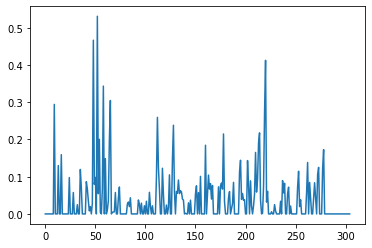

0.09794955253601073

In [26]:
from matplotlib import pyplot
pyplot.plot(f2b_estimated)
pyplot.show()
f2b_estimated[50]

In [18]:
log_likelihood_global(f2b_estimated, data, likelihood_blocks)

-45787.55500429494

In [29]:
log_likelihood_global(f2b_estimated, data, likelihood_blocks)

-46662.43673206189

In [15]:
for index, proba in enumerate(f2b_estimated):
    if proba < 0:
        f2b_estimated[index] = 0
    if proba > 1: 
        f2b_estimated[index] = 1
log_likelihood_global(f2b_estimated, data, likelihood_blocks)

-46561.9644566473

In [8]:
from matplotlib import pyplot
pyplot.plot(f2b_estimated)
pyplot.show()

NameError: name 'f2b_estimated' is not defined

In [34]:
component = 52
f2b_test = [0 for _ in range(len(data.runs))]

nbr_tests = 100
step_size = 1/nbr_tests
partial_derivative_value = [0 for _ in range(nbr_tests)]
for i in range(nbr_tests):
    for trip_id in data.trips.index:
        partial_derivative_value[i] += indiv_log_likelihood_partial_diff(trip_id, data, likelihood_blocks, f2b_test, component)
    f2b_test[component] += step_size
print(f2b_test[52]- step_size)



0.9900000000000007


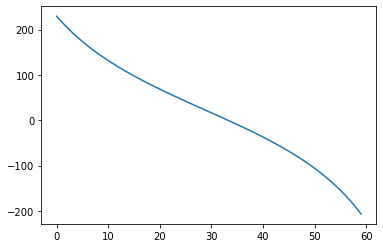

In [35]:
from matplotlib import pyplot
pyplot.plot(partial_derivative_value[20:80])
pyplot.show()

In [20]:
for i in range(10):
    if i ==4:
        pass
    print(i)

0
1
2
3
4
5
6
7
8
9
